# Downstream adaption with MiniMol

This example shows how MiniMol can featurise small molecules that will then serve as an input to another model trained on a small downstream dataset from TDC ADMET. This allows to transfer the knowledge from the pre-trained MiniMol to another task. 

Before we start, let's make sure that the TDC package is installed in the environment. It takes a while, that's why we don't include it in the dependencies.

In [1]:
# %pip install PyTDC

## Step 1: Getting the data
Next, we will build a predictor for the `HIA Hou` dataset, one of the binary classification benchmarks from TDC ADMET group. HIA stands for human intestinal absorption (HIA), which is related to the ability to absorb a substance through the gastrointestinal system into the bloodstream of the human body.

We then split the data based on molecular scaffolds into training, validation and test sets. 

In [2]:
from tdc.benchmark_group import admet_group

DATASET_NAME = 'hia_hou'

admet = admet_group(path="admet-data/")

mols_test = admet.get(DATASET_NAME)['test']
mols_train, mols_val = admet.get_train_valid_split(benchmark=DATASET_NAME, split_type='scaffold', seed=42)

Found local copy...
generating training, validation splits...
generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 3452.13it/s]


In [3]:
print(f"Dataset - {DATASET_NAME}\n")
print(f"Val split ({len(mols_val)} mols): \n{mols_val.head()}\n")
print(f"Test split ({len(mols_test)} mols): \n{mols_test.head()}\n")
print(f"Train split ({len(mols_train)} mols): \n{mols_train.head()}\n")

Dataset - hia_hou

Val split (58 mols): 
                 Drug_ID                                               Drug  Y
0         Atracurium.mol  COc1ccc(C[C@H]2c3cc(OC)c(OC)cc3CC[N@@+]2(C)CCC...  0
1  Succinylsulfathiazole          O=C(O)CCC(=O)Nc1ccc(S(=O)(=O)Nc2nccs2)cc1  0
2            Ticarcillin  CC1(C)S[C@H]2[C@@H](NC(=O)[C@@H](C(=O)O)c3ccsc...  0
3          Raffinose.mol  OC[C@@H]1O[C@@H](OC[C@@H]2O[C@@H](O[C@]3(CO)O[...  0
4          Triamcinolone  C[C@@]12C=CC(=O)C=C1CC[C@@H]1[C@H]3C[C@@H](O)[...  1

Test split (117 mols): 
                Drug_ID                                               Drug  Y
0         Trazodone.mol         O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12  1
1          Lisuride.mol  CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@@...  1
2  Methylergonovine.mol  CC[C@H](CO)NC(=O)[C@H]1C=C2c3cccc4[nH]cc(c34)C...  1
3      Methysergide.mol  CC[C@H](CO)NC(=O)[C@H]1C=C2c3cccc4c3c(cn4C)C[C...  1
4       Moclobemide.mol                       O=C(NCCN1CCOCC1)c1ccc(Cl

## Step 2: Generating molecular fingerprints
Now that we have the splits, we will use MiniMol to embed all molecules. The embedding will be added as an extra column in the dataframe returned by TDC.

In [4]:
from minimol import Minimol

featuriser = Minimol()

In [5]:
mols_val['Embedding'] = featuriser(list(mols_val['Drug']))
mols_test['Embedding'] = featuriser(list(mols_test['Drug']))
mols_train['Embedding'] = featuriser(list(mols_train['Drug']))

100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


The model is small, so it took us 7.3 seconds to generate the embeddings for almost 600 molecules. Here is a preview after the new column has been added:

In [6]:
print(mols_train.head())

           Drug_ID                                               Drug  Y  \
0        Guanadrel                      N=C(N)NC[C@@H]1COC2(CCCCC2)O1  1   
1      Cefmetazole  CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3n...  0   
2   Zonisamide.mol                           NS(=O)(=O)Cc1noc2ccccc12  1   
3   Furosemide.mol            NS(=O)(=O)c1cc(Cl)cc(NCc2ccco2)c1C(=O)O  1   
4  Telmisartan.mol  CCCc1nc2c(n1Cc1ccc(-c3ccccc3C(=O)O)cc1)=C[C@H]...  1   

                                           Embedding  
0  [1.8960192, 0.59439033, -1.0357288, 0.3129699,...  
1  [-1.0467318, 0.2789424, -0.503565, -1.1411885,...  
2  [0.8090856, 0.87236685, -0.5038779, 0.53158706...  
3  [-0.16701677, -0.22239566, 0.40283644, 0.18509...  
4  [-0.67387235, -0.058095545, -0.13308619, -0.14...  


## Step 3: Training a model
Now that the molecules are featurised leverging the representation MiniMol learned during its pre-training, we will set up a training and evaluation loop of a simple Multi-Layer Perceptron model using PyTorch.

Let's start by defining a new class for the dataset and then creating a separate dataloader for each split.

In [7]:
from torch.utils.data import DataLoader, Dataset
    
class AdmetDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples['Embedding'].tolist()
        self.targets = [float(target) for target in samples['Y'].tolist()]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = torch.tensor(self.samples[idx])
        target = torch.tensor(self.targets[idx])
        return sample, target

val_loader = DataLoader(AdmetDataset(mols_val), batch_size=128, shuffle=False)
test_loader = DataLoader(AdmetDataset(mols_test), batch_size=128, shuffle=False)
train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)

Our model is a simple 3-layer perceptron with batch normalisation and dropout. We also add a residual connection that before the last layer concatates the the input features with the output from the second to last layer.

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class TaskHead(nn.Module):
    def __init__(self):
        super(TaskHead, self).__init__()
        self.dense1 = nn.Linear(1024, 1024)
        self.dense2 = nn.Linear(1024, 1024)
        self.dense3 = nn.Linear(1024, 1024)
        self.dense4 = nn.Linear(2048, 1)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        original_x = x

        x = self.dense1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.dense2(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.dense3(x)
        x = self.bn3(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = torch.cat((x, original_x), dim=1)
        x = self.dense4(x)
        
        return self.sigmoid(x)

Below we declare the basic hyperparamters, optimiser, loss function and learning rate scheduler. We build a model factory that allows us to instatiate a fresh copy of everything, which will become useful later.

In [65]:
import math
import torch.optim as optim

lr = 0.007
epochs = 25
warmup = 12

loss_fn = nn.BCELoss()

def model_factory():
    model = TaskHead()
    lr_fn = lambda epoch: lr * (1 + math.cos(math.pi * (epoch - warmup) / (epochs - warmup))) / 2
    optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    lr_scheduler = optim.lr_scheduler.LambdaLR(optimiser, lr_fn)
    return model, optimiser, lr_scheduler

For evaluation we will use both AUROC and Average Precision metrics. The reported loss would be an average across all samples in the epoch.

In [35]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate(predictor, dataloader, loss_fn):
    predictor.eval()
    total_loss = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            probs = predictor(inputs).squeeze()
            loss = loss_fn(probs, targets)
            total_loss += loss.item()
            all_probs.extend(probs.tolist())
            all_targets.extend(targets.tolist())

    loss = total_loss / len(dataloader)
    
    return (
        loss,
        roc_auc_score(all_targets, all_probs),
        average_precision_score(all_targets, all_probs)
    )

Training is a rather standard boilerplate loop: 

In [36]:
def train_one_epoch(predictor, optimiser, lr_scheduler, loss_fn, epoch, verbose=True):
    predictor.train()        
    train_loss = 0

    lr_scheduler.step(epoch)
    for inputs, targets in train_loader:
        optimiser.zero_grad()
        probs = predictor(inputs).squeeze()
        loss = loss_fn(probs, targets)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    val_loss, auroc, avpr = evaluate(predictor, val_loader, loss_fn)

    if verbose:
        print(
            f"## Epoch {epoch+1}\t"
            f"train_loss: {train_loss:.4f}\t"
            f"val_loss: {val_loss:.4f}\t"
            f"val_auroc: {auroc:.4f}\t"
            f"val_avpr: {avpr:.4f}"
        )
    return predictor

And now, let's see how good our model gets after training... 🚀

In [71]:
model, optimiser, lr_scheduler = model_factory()

val_loss, val_auroc, val_avpr = evaluate(model, val_loader, loss_fn)
print(
    f"## Epoch 0\t"
    f"train_loss: ------\t"
    f"val_loss: {val_loss:.4f}\t"
    f"val_auroc: {val_auroc:.4f}\t"
    f"val_avpr: {val_avpr:.4f}"
)

for epoch in range(epochs):
    model = train_one_epoch(model, optimiser, lr_scheduler, loss_fn, epoch)

test_loss, test_auroc, test_avpr = evaluate(model, test_loader, loss_fn)
print(
    f"test_loss: {test_loss:.4f}\n"
    f"test_auroc: {test_auroc:.4f}\n"
    f"test_avpr: {test_avpr:.4f}"
)

## Epoch 0	train_loss: ------	val_loss: 0.9141	val_auroc: 0.5689	val_avpr: 0.9325
## Epoch 1	train_loss: 0.9210	val_loss: 0.9622	val_auroc: 0.5514	val_avpr: 0.9229
## Epoch 2	train_loss: 0.8996	val_loss: 0.9456	val_auroc: 0.6241	val_avpr: 0.9400
## Epoch 3	train_loss: 0.8682	val_loss: 0.8676	val_auroc: 0.7118	val_avpr: 0.9557
## Epoch 4	train_loss: 0.8165	val_loss: 0.7769	val_auroc: 0.7469	val_avpr: 0.9598
## Epoch 5	train_loss: 0.7175	val_loss: 0.6671	val_auroc: 0.7393	val_avpr: 0.9568
## Epoch 6	train_loss: 0.6322	val_loss: 0.5769	val_auroc: 0.7669	val_avpr: 0.9619
## Epoch 7	train_loss: 0.5351	val_loss: 0.4929	val_auroc: 0.7945	val_avpr: 0.9663
## Epoch 8	train_loss: 0.4399	val_loss: 0.4266	val_auroc: 0.8321	val_avpr: 0.9743
## Epoch 9	train_loss: 0.3596	val_loss: 0.3647	val_auroc: 0.8596	val_avpr: 0.9800
## Epoch 10	train_loss: 0.2960	val_loss: 0.3294	val_auroc: 0.8697	val_avpr: 0.9819
## Epoch 11	train_loss: 0.2392	val_loss: 0.2968	val_auroc: 0.8997	val_avpr: 0.9869
## Epoch 12	tr

The model trained in just 1.4s, reaching AUROC on the test set of 0.9658. Pretty good!

## Step 4: Improvements

The result can be further improved. One problem is that the accuracy is quite sensitive to both the train-val splitting (reminder - we use scaffold splitting strategy) and the weight initialisation. Let's visualise the distribution by training a few models:

In [72]:
def dataloader_factory(seed):
    mols_train, mols_val = admet.get_train_valid_split(benchmark=DATASET_NAME, split_type='scaffold', seed=seed)

    mols_val['Embedding'] = featuriser(list(mols_val['Drug']))
    mols_train['Embedding'] = featuriser(list(mols_train['Drug']))

    val_loader = DataLoader(AdmetDataset(mols_val), batch_size=128, shuffle=False)
    train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)

    return val_loader, train_loader

generating training, validation splits...
100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


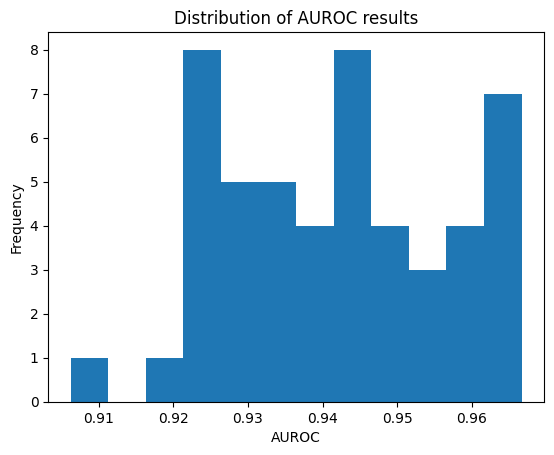

In [74]:
import matplotlib.pyplot as plt

results = []
repeats = 50
val_loader, train_loader = dataloader_factory(42)

for _ in range(repeats):
    model, optimiser, lr_scheduler = model_factory()
    for epoch in range(epochs):
        model = train_one_epoch(model, optimiser, lr_scheduler, loss_fn, epoch, verbose=False)
    _, auroc, _ = evaluate(model, val_loader, loss_fn)
    results.append(auroc)

plt.hist(results, bins=12)
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.title('Distribution of AUROC results')
plt.show()

To mitigate the problem, we adapt two techniques:

- Ensembling models trained on different folds of train-val data. Since the training is so fast, fitting a few addtional models is not a big deal. The train-val splitting method is provided by TDC.

- Rather than choosing the model at the last epoch, we will use best validation loss to decide which one to choose.

Below we implement a method that create a new training and validation dataloader for each fold, and also a method for ensemble-based evaluationm, where probabiltiies for each predition are averaged across all models in the ensemble.

In [56]:
def evaluate_ensemble(predictors, dataloader, loss_fn):
    total_loss = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        
        for inputs, targets in dataloader:
            model_outputs = [predictor(inputs).squeeze() for predictor in predictors]
            averaged_output = torch.mean(torch.stack(model_outputs, dim=0), dim=0)

            loss = loss_fn(averaged_output, targets)
            total_loss += loss.item()

            all_probs.extend(averaged_output.tolist())
            all_targets.extend(targets.tolist())

    loss = total_loss / len(dataloader)
    return loss, roc_auc_score(all_targets, all_probs), average_precision_score(all_targets, all_probs)

Finally, let's see how much better our model gets!

In [57]:
from copy import deepcopy

seeds = [1, 2, 3, 4, 5]

best_models = []
num_folds = 5

for seed in seeds:
    val_loader, train_loader = dataloader_factory(seed)
    model, optimiser, lr_scheduler = model_factory()

    best_epoch = {"model": None, "result": None}
    for epoch in range(epochs):
        model = train_one_epoch(model, optimiser, lr_scheduler, loss_fn, epoch)
        val_loss, auroc, _ = evaluate(model, val_loader, loss_fn)

        if best_epoch['model'] is None:
            best_epoch['model'] = deepcopy(model)
            best_epoch['result'] = auroc
        else:
            best_epoch['model'] = best_epoch['model'] if best_epoch['result'] <= val_loss else deepcopy(model)
            best_epoch['result'] = best_epoch['result'] if best_epoch['result'] <= val_loss else val_loss 

    best_models.append(best_epoch['model'])

test_loss, test_auroc, test_avpr = evaluate_ensemble(best_models, test_loader, loss_fn)
print(
    f"test_loss: {test_loss:.4f}\n"
    f"test_auroc: {test_auroc:.4f}\n"
    f"test_avpr: {test_avpr:.4f}"
)

generating training, validation splits...
100%|██████████| 5/5 [00:00<00:00,  7.63it/s]


## Epoch 1	train_loss: 0.6808	val_loss: 0.6325	val_auroc: 0.6947	val_avpr: 0.9504
## Epoch 2	train_loss: 0.5717	val_loss: 0.5438	val_auroc: 0.9048	val_avpr: 0.9856
## Epoch 3	train_loss: 0.4741	val_loss: 0.4252	val_auroc: 0.9636	val_avpr: 0.9951
## Epoch 4	train_loss: 0.3665	val_loss: 0.3521	val_auroc: 0.9720	val_avpr: 0.9964
## Epoch 5	train_loss: 0.3035	val_loss: 0.3009	val_auroc: 0.9720	val_avpr: 0.9964
## Epoch 6	train_loss: 0.2312	val_loss: 0.2586	val_auroc: 0.9776	val_avpr: 0.9971
## Epoch 7	train_loss: 0.1863	val_loss: 0.2367	val_auroc: 0.9720	val_avpr: 0.9964
## Epoch 8	train_loss: 0.1532	val_loss: 0.2265	val_auroc: 0.9692	val_avpr: 0.9960
## Epoch 9	train_loss: 0.1228	val_loss: 0.2075	val_auroc: 0.9748	val_avpr: 0.9967
## Epoch 10	train_loss: 0.1009	val_loss: 0.1981	val_auroc: 0.9692	val_avpr: 0.9961
## Epoch 11	train_loss: 0.0835	val_loss: 0.2084	val_auroc: 0.9636	val_avpr: 0.9954
## Epoch 12	train_loss: 0.0720	val_loss: 0.1954	val_auroc: 0.9692	val_avpr: 0.9961
## Epoch 13	t

generating training, validation splits...


## Epoch 25	train_loss: 0.0357	val_loss: 0.2192	val_auroc: 0.9608	val_avpr: 0.9950


100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


## Epoch 1	train_loss: 0.6114	val_loss: 0.6144	val_auroc: 0.4453	val_avpr: 0.9251
## Epoch 2	train_loss: 0.5115	val_loss: 0.5596	val_auroc: 0.7358	val_avpr: 0.9654
## Epoch 3	train_loss: 0.4120	val_loss: 0.4695	val_auroc: 0.8453	val_avpr: 0.9825
## Epoch 4	train_loss: 0.3299	val_loss: 0.3754	val_auroc: 0.9057	val_avpr: 0.9904
## Epoch 5	train_loss: 0.2738	val_loss: 0.3324	val_auroc: 0.9283	val_avpr: 0.9929
## Epoch 6	train_loss: 0.2157	val_loss: 0.2726	val_auroc: 0.9509	val_avpr: 0.9953
## Epoch 7	train_loss: 0.1716	val_loss: 0.2411	val_auroc: 0.9509	val_avpr: 0.9953
## Epoch 8	train_loss: 0.1371	val_loss: 0.2306	val_auroc: 0.9434	val_avpr: 0.9945
## Epoch 9	train_loss: 0.1120	val_loss: 0.2240	val_auroc: 0.9434	val_avpr: 0.9945
## Epoch 10	train_loss: 0.0934	val_loss: 0.2051	val_auroc: 0.9472	val_avpr: 0.9949
## Epoch 11	train_loss: 0.0735	val_loss: 0.1902	val_auroc: 0.9509	val_avpr: 0.9953
## Epoch 12	train_loss: 0.0597	val_loss: 0.1983	val_auroc: 0.9547	val_avpr: 0.9957
## Epoch 13	t

generating training, validation splits...


## Epoch 25	train_loss: 0.0243	val_loss: 0.1744	val_auroc: 0.9623	val_avpr: 0.9964


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


## Epoch 1	train_loss: 0.7779	val_loss: 0.7495	val_auroc: 0.6442	val_avpr: 0.9455
## Epoch 2	train_loss: 0.6510	val_loss: 0.6275	val_auroc: 0.8814	val_avpr: 0.9829
## Epoch 3	train_loss: 0.5298	val_loss: 0.4950	val_auroc: 0.9455	val_avpr: 0.9936
## Epoch 4	train_loss: 0.4180	val_loss: 0.4006	val_auroc: 0.9391	val_avpr: 0.9930
## Epoch 5	train_loss: 0.3246	val_loss: 0.3175	val_auroc: 0.9487	val_avpr: 0.9940
## Epoch 6	train_loss: 0.2648	val_loss: 0.2739	val_auroc: 0.9519	val_avpr: 0.9943
## Epoch 7	train_loss: 0.2018	val_loss: 0.2416	val_auroc: 0.9519	val_avpr: 0.9942
## Epoch 8	train_loss: 0.1618	val_loss: 0.2163	val_auroc: 0.9423	val_avpr: 0.9928
## Epoch 9	train_loss: 0.1331	val_loss: 0.1958	val_auroc: 0.9519	val_avpr: 0.9942
## Epoch 10	train_loss: 0.1092	val_loss: 0.1844	val_auroc: 0.9295	val_avpr: 0.9905
## Epoch 11	train_loss: 0.0894	val_loss: 0.2112	val_auroc: 0.9103	val_avpr: 0.9874
## Epoch 12	train_loss: 0.0781	val_loss: 0.1982	val_auroc: 0.8974	val_avpr: 0.9854
## Epoch 13	t

generating training, validation splits...


## Epoch 25	train_loss: 0.0274	val_loss: 0.1917	val_auroc: 0.9167	val_avpr: 0.9884


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


## Epoch 1	train_loss: 0.5018	val_loss: 0.4939	val_auroc: 0.6065	val_avpr: 0.9578
## Epoch 2	train_loss: 0.4081	val_loss: 0.4194	val_auroc: 0.7917	val_avpr: 0.9718
## Epoch 3	train_loss: 0.3300	val_loss: 0.3498	val_auroc: 0.7824	val_avpr: 0.9699
## Epoch 4	train_loss: 0.2625	val_loss: 0.2942	val_auroc: 0.7778	val_avpr: 0.9682
## Epoch 5	train_loss: 0.2120	val_loss: 0.2513	val_auroc: 0.8009	val_avpr: 0.9754
## Epoch 6	train_loss: 0.1724	val_loss: 0.2320	val_auroc: 0.8287	val_avpr: 0.9809
## Epoch 7	train_loss: 0.1437	val_loss: 0.2055	val_auroc: 0.8426	val_avpr: 0.9834
## Epoch 8	train_loss: 0.1141	val_loss: 0.2141	val_auroc: 0.8380	val_avpr: 0.9831
## Epoch 9	train_loss: 0.0895	val_loss: 0.1971	val_auroc: 0.8657	val_avpr: 0.9867
## Epoch 10	train_loss: 0.0727	val_loss: 0.1984	val_auroc: 0.8889	val_avpr: 0.9900
## Epoch 11	train_loss: 0.0630	val_loss: 0.2111	val_auroc: 0.8843	val_avpr: 0.9895
## Epoch 12	train_loss: 0.0550	val_loss: 0.1992	val_auroc: 0.8935	val_avpr: 0.9906
## Epoch 13	t

generating training, validation splits...


## Epoch 24	train_loss: 0.0190	val_loss: 0.2027	val_auroc: 0.9120	val_avpr: 0.9926
## Epoch 25	train_loss: 0.0224	val_loss: 0.2053	val_auroc: 0.9120	val_avpr: 0.9926


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]
featurizing_smiles, batch=13: 31it [00:00, 121.11it/s]                        
100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


## Epoch 1	train_loss: 0.4073	val_loss: 0.4200	val_auroc: 0.6391	val_avpr: 0.9206
## Epoch 2	train_loss: 0.3340	val_loss: 0.3485	val_auroc: 0.8747	val_avpr: 0.9832
## Epoch 3	train_loss: 0.2812	val_loss: 0.2936	val_auroc: 0.8346	val_avpr: 0.9760
## Epoch 4	train_loss: 0.2256	val_loss: 0.2560	val_auroc: 0.8571	val_avpr: 0.9797
## Epoch 5	train_loss: 0.1839	val_loss: 0.2322	val_auroc: 0.8872	val_avpr: 0.9845
## Epoch 6	train_loss: 0.1553	val_loss: 0.2202	val_auroc: 0.8997	val_avpr: 0.9862
## Epoch 7	train_loss: 0.1257	val_loss: 0.2168	val_auroc: 0.9023	val_avpr: 0.9866
## Epoch 8	train_loss: 0.1139	val_loss: 0.2126	val_auroc: 0.8897	val_avpr: 0.9842
## Epoch 9	train_loss: 0.0866	val_loss: 0.2145	val_auroc: 0.8622	val_avpr: 0.9774
## Epoch 10	train_loss: 0.0667	val_loss: 0.2120	val_auroc: 0.9123	val_avpr: 0.9875
## Epoch 11	train_loss: 0.0523	val_loss: 0.2135	val_auroc: 0.8822	val_avpr: 0.9829
## Epoch 12	train_loss: 0.0512	val_loss: 0.2125	val_auroc: 0.9073	val_avpr: 0.9877
## Epoch 13	t

As we can see, in less than 15s the ensemble was trained and reached performance of 0.9765 in AUROC on the test set. That's a decent improvement coming from 0.9658 that we got for a single model. More importantly, the ensemble is not senstitive to which part of the data is used for validation (because we train n models on n folds), and is less sensitive to the intialisation because we intialise n models getting somewhere close to an average performance. 

The results could be further improved by sweeping hyperparameters. Considering the low cost of fitting these tiny models, it would still be very fast. The results reported in the paper are slighly better than what we show here, thanks to sweeping that we performed for each task.  